In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
plt.style.use('ggplot')

In [2]:
data = pd.read_csv('User churn.csv')
data.columns = data.columns.str.lower()
data.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


<b>Encoding binary features</b>

In [3]:
# Define the mapping dictionary
mapping = {'Yes': 1, 'No': 0}
# Binary features
binary = []
# Apply the mapping to each column where we have only 'Yes' and 'No' values
for col in data.columns:
    if set(data[col].unique()).issubset({'Yes', 'No'}):
        binary.append(col)
        data[col] = data[col].map(mapping)

<b>Visualizing distributions</b>

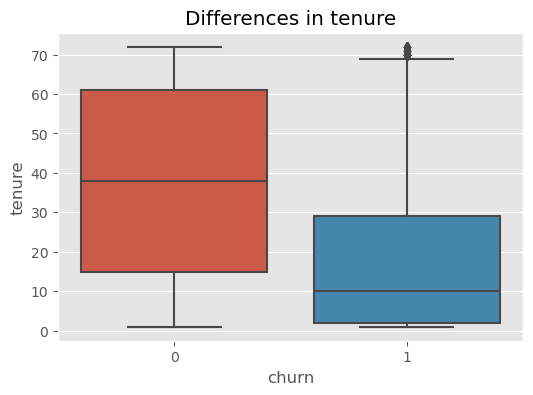

In [4]:
plt.figure(figsize=(6, 4))
sns.boxplot(x = 'churn', y = 'tenure', data = data)
plt.title('Differences in tenure')
plt.show()

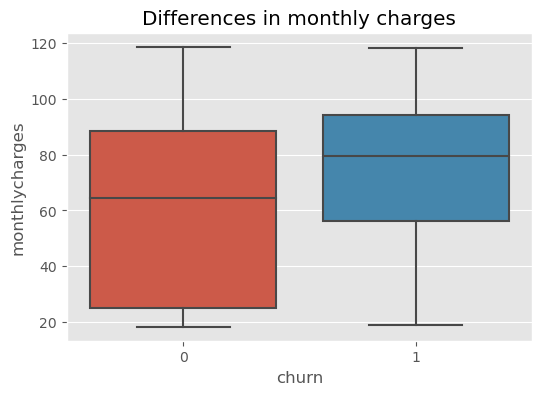

In [5]:
plt.figure(figsize=(6, 4))
sns.boxplot(x = 'churn', y = 'monthlycharges', data = data)
plt.title('Differences in monthly charges')
plt.show()

The probability of churn is higher if monthly charges bigger and less if tenure is longer

<b>Separate categorical and numerical columns</b>

In [6]:
# Separate the identifier and target variable names as lists
custid = ['customerid']
target = ['churn']
# Separate categorical and numeric column names as lists
categorical = data.nunique()[data.nunique()<10].keys().tolist()
categorical = [x for x in categorical if x not in binary]
binary.remove(target[0])
numerical = [col for col in data.columns if col not in custid + target + categorical + binary]

<b>Standardization</b>

Centers distribution around the mean. Calculates the number of standard deviations away from the mean each point is.

In [7]:
# Fit the scaler to numerical columns
scaled_numerical = StandardScaler().fit_transform(data[numerical])
# Build a dataframe
scaled_numerical = pd.DataFrame(data=scaled_numerical, columns=numerical)
scaled_numerical.head()

,tenure,monthlycharges,totalcharges
0,-1.280248,-1.161694,-0.994194
1,0.064303,-0.260878,-0.173740
2,-1.239504,-0.363923,-0.959649
3,0.512486,-0.747850,-0.195248
4,-1.239504,0.196178,-0.940457


<b>One hot encoding</b>

In [8]:
# One-hot encoding categorical variables
data = pd.get_dummies(data=data, columns=categorical, drop_first=True)
data.head()

,customerid,partner,dependents,tenure,phoneservice,paperlessbilling,monthlycharges,totalcharges,churn,gender_Male,...,techsupport_Yes,streamingtv_No internet service,streamingtv_Yes,streamingmovies_No internet service,streamingmovies_Yes,contract_One year,contract_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,7590-VHVEG,1,0,1,0,1,29.85,29.85,0,0,...,0,0,0,0,0,0,0,0,1,0
1,5575-GNVDE,0,0,34,1,0,56.95,1889.50,0,1,...,0,0,0,0,0,1,0,0,0,1
2,3668-QPYBK,0,0,2,1,1,53.85,108.15,1,1,...,0,0,0,0,0,0,0,0,0,1
3,7795-CFOCW,0,0,45,0,0,42.30,1840.75,0,1,...,1,0,0,0,0,1,0,0,0,0
4,9237-HQITU,0,0,2,1,1,70.70,151.65,1,0,...,0,0,0,0,0,0,0,0,1,0


<b>Bringing it all together</b>

In [9]:
# Drop non-scaled numerical columns
data = data.drop(columns=numerical, axis=1)
# Merge the non-numerical with the scaled numerical data
data = data.merge(right=scaled_numerical,
                     how='left',
                     left_index=True,
                     right_index=True
                    )
data.head()

,customerid,partner,dependents,phoneservice,paperlessbilling,churn,gender_Male,seniorcitizen_1,multiplelines_No phone service,multiplelines_Yes,...,streamingmovies_No internet service,streamingmovies_Yes,contract_One year,contract_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,tenure,monthlycharges,totalcharges
0,7590-VHVEG,1,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,-1.280248,-1.161694,-0.994194
1,5575-GNVDE,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0.064303,-0.260878,-0.173740
2,3668-QPYBK,0,0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,1,-1.239504,-0.363923,-0.959649
3,7795-CFOCW,0,0,0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0.512486,-0.747850,-0.195248
4,9237-HQITU,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,1,0,-1.239504,0.196178,-0.940457


<b>Dropping correlated features</b>

Highly correlated features can be droped. They provide no additional information to the model.

In [10]:
data.corr()

,partner,dependents,phoneservice,paperlessbilling,churn,gender_Male,seniorcitizen_1,multiplelines_No phone service,multiplelines_Yes,internetservice_Fiber optic,...,streamingmovies_No internet service,streamingmovies_Yes,contract_One year,contract_Two year,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,tenure,monthlycharges,totalcharges
partner,1.000000,0.452269,0.018397,-0.013957,-0.149982,-0.001379,0.016957,-0.018397,0.142561,0.001235,...,-0.000286,0.118108,0.083067,0.247334,0.082327,-0.083207,-0.096948,0.381912,0.097825,0.319072
dependents,0.452269,1.000000,-0.001078,-0.110131,-0.163128,0.010349,-0.210550,0.001078,-0.024307,-0.164101,...,0.138383,-0.038375,0.069222,0.201699,0.061134,-0.149274,0.056448,0.163386,-0.112343,0.064653
phoneservice,0.018397,-0.001078,1.000000,0.016696,0.011691,-0.007515,0.008392,-1.000000,0.279530,0.290183,...,0.171817,-0.033477,-0.003142,0.004442,-0.006916,0.002747,-0.004463,0.007877,0.248033,0.113008
paperlessbilling,-0.013957,-0.110131,0.016696,1.000000,0.191454,-0.011902,0.156258,-0.016696,0.163746,0.326470,...,-0.320592,0.211583,-0.052278,-0.146281,-0.013726,0.208427,-0.203981,0.004823,0.351930,0.157830
churn,-0.149982,-0.163128,0.011691,0.191454,1.000000,-0.008545,0.150541,-0.011691,0.040033,0.307463,...,-0.227578,0.060860,-0.178225,-0.301552,-0.134687,0.301455,-0.090773,-0.354049,0.192858,-0.199484
gender_Male,-0.001379,0.010349,-0.007515,-0.011902,-0.008545,1.000000,-0.001819,0.007515,-0.008883,-0.011189,...,0.004745,-0.010105,0.007755,-0.003603,0.001632,0.000844,0.013199,0.005285,-0.013779,0.000048
seniorcitizen_1,0.016957,-0.210550,0.008392,0.156258,0.150541,-0.001819,1.000000,-0.008392,0.142996,0.254923,...,-0.182519,0.119842,-0.046491,-0.116205,-0.024359,0.171322,-0.152987,0.015683,0.219874,0.102411
multiplelines_No phone service,-0.018397,0.001078,-1.000000,-0.016696,-0.011691,0.007515,-0.008392,1.000000,-0.279530,-0.290183,...,-0.171817,0.033477,0.003142,-0.004442,0.006916,-0.002747,0.004463,-0.007877,-0.248033,-0.113008
multiplelines_Yes,0.142561,-0.024307,0.279530,0.163746,0.040033,-0.008883,0.142996,-0.279530,1.000000,0.366420,...,-0.210794,0.259194,-0.003594,0.106618,0.060319,0.083583,-0.227672,0.332399,0.490912,0.469042
internetservice_Fiber optic,0.001235,-0.164101,0.290183,0.326470,0.307463,-0.011189,0.254923,-0.290183,0.366420,1.000000,...,-0.465736,0.322457,-0.076809,-0.209965,-0.050552,0.335763,-0.305984,0.017930,0.787195,0.360769


In [11]:
# Compute the correlation matrix
corr_matrix = data.corr().abs()

# Define a threshold for high correlation
threshold = 0.9

# Identify highly correlated features
to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if corr_matrix.iloc[i, j] > threshold:
            colname = corr_matrix.columns[i]
            to_drop.add(colname)
to_drop

{'deviceprotection_No internet service',
 'multiplelines_No phone service',
 'onlinebackup_No internet service',
 'onlinesecurity_No internet service',
 'streamingmovies_No internet service',
 'streamingtv_No internet service',
 'techsupport_No internet service'}

In [12]:
# Drop highly correlated features
data_reduced = data.drop(columns=to_drop)

<b>Churn prediction</b>

Model selection: 1. Logistic regression (simple and interpretable bu can't capture complex relationship) 2. Random forests 3. Support vector machines

<b>Support Vector Classifier</b>

In [13]:
features = [x for x in data_reduced.columns if x not in custid + target]
X = data_reduced[features]
Y = np.ravel(data_reduced[target])
train_X, test_X,  train_Y, test_Y = train_test_split(X, Y, 
                                                    test_size=0.25,
                                                    random_state=99)
# Print shapes of the datasets
print(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape)

(5274, 23) (5274,) (1758, 23) (1758,)


In [14]:
# Initialize the SVC classifier
svc = SVC(C=1, kernel='linear', random_state=99, probability=True)
# Fit the classifier
svc.fit(train_X, train_Y)
# Predict the label
pred_Y = svc.predict(test_X)
# Evaluate the model
accuracy = accuracy_score(test_Y, pred_Y)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8220


In [15]:
# Print classification report
print(classification_report(test_Y, pred_Y))

              precision    recall  f1-score   support

           0       0.86      0.92      0.88      1309
           1       0.69      0.55      0.61       449

    accuracy                           0.82      1758
   macro avg       0.77      0.73      0.75      1758
weighted avg       0.81      0.82      0.81      1758



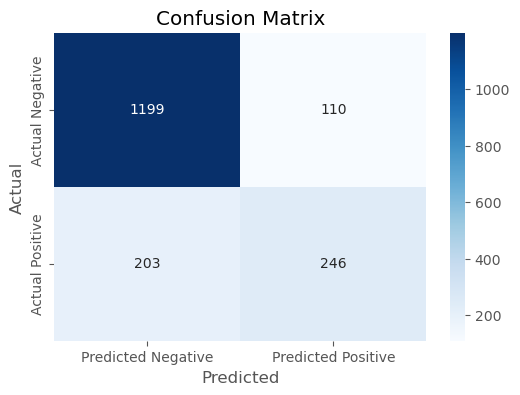

In [16]:
# get confusion matrix
conf_matrix = confusion_matrix(test_Y, pred_Y)
# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


<b>Logistic Regression Classifier</b>

In [17]:
# Initialize the logreg classifier
logreg = LogisticRegression(C=1, solver='liblinear', random_state=99)
# Fit the classifier
logreg.fit(train_X, train_Y)
# Predict the label
pred_Y = logreg.predict(test_X)
# Evaluate the model
accuracy = accuracy_score(test_Y, pred_Y)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8208


In [18]:
# Print classification report
print(classification_report(test_Y, pred_Y))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1309
           1       0.69      0.54      0.61       449

    accuracy                           0.82      1758
   macro avg       0.77      0.73      0.75      1758
weighted avg       0.81      0.82      0.81      1758



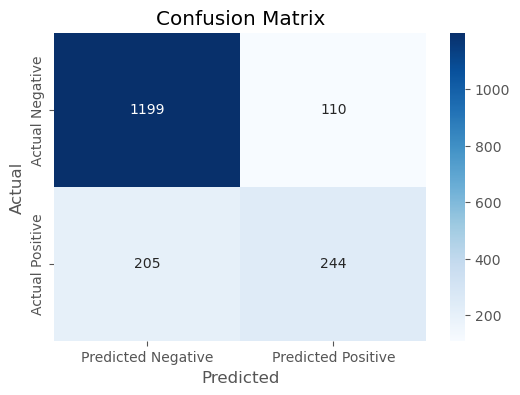

In [19]:
# get confusion matrix
conf_matrix = confusion_matrix(test_Y, pred_Y)
# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<b>Decision Tree Classifier</b>

In [20]:
# Initialize the Decision Tree classifier
dtc = DecisionTreeClassifier(random_state=99)
# Fit the classifier
dtc.fit(train_X, train_Y)
# Predict on the test data
pred_Y = dtc.predict(test_X)
# Evaluate the model
accuracy = accuracy_score(test_Y, pred_Y)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7264


In [21]:
# Print classification report
print(classification_report(test_Y, pred_Y))

              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1309
           1       0.47      0.49      0.48       449

    accuracy                           0.73      1758
   macro avg       0.64      0.65      0.65      1758
weighted avg       0.73      0.73      0.73      1758



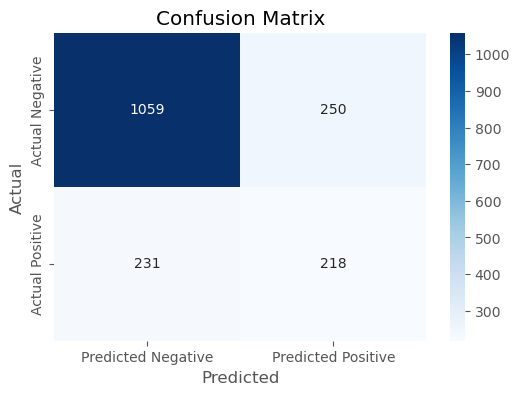

In [22]:
# get confusion matrix
conf_matrix = confusion_matrix(test_Y, pred_Y)
# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<b>Random Forest Classifier</b>

In [23]:
# Initialize the Random Forest classifier
rfc = RandomForestClassifier(random_state=99)
# Fit the classifier
rfc.fit(train_X, train_Y)
# Predict on the test data
pred_Y = rfc.predict(test_X)
# Evaluate the model
accuracy = accuracy_score(test_Y, pred_Y)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.8072


In [24]:
# Print classification report
print(classification_report(test_Y, pred_Y))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      1309
           1       0.67      0.49      0.56       449

    accuracy                           0.81      1758
   macro avg       0.75      0.70      0.72      1758
weighted avg       0.80      0.81      0.80      1758



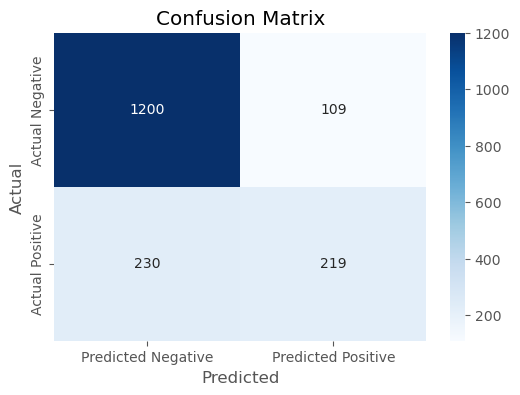

In [25]:
# get confusion matrix
conf_matrix = confusion_matrix(test_Y, pred_Y)
# Plot confusion matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Negative', 'Predicted Positive'], yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<b>ROC curve</b>

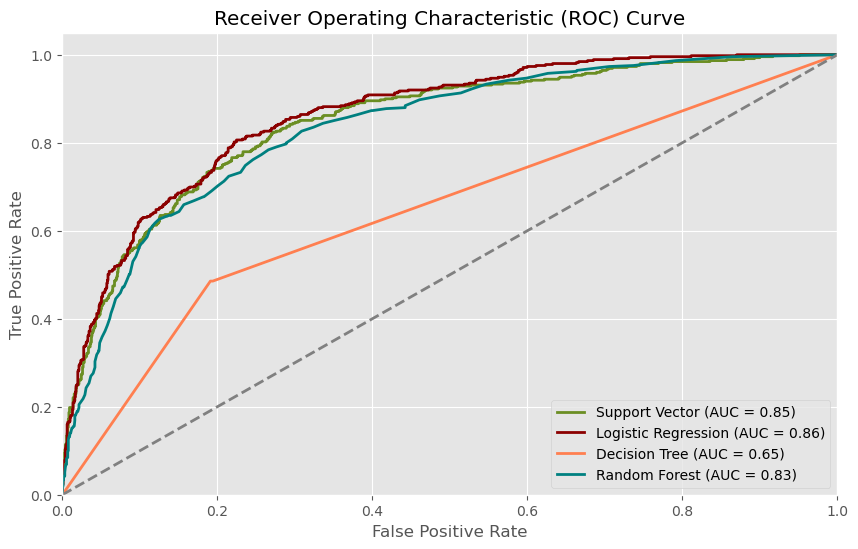

In [26]:
# Predict probabilities on the test data
y_pred_prob_sv = svc.predict_proba(test_X)[:, 1]
y_pred_prob_lr = logreg.predict_proba(test_X)[:, 1]
y_pred_prob_dt = dtc.predict_proba(test_X)[:, 1]
y_pred_prob_rf = rfc.predict_proba(test_X)[:, 1]

# Compute ROC curve and AUC for Support Vector
fpr_sv, tpr_sv, _ = roc_curve(test_Y, y_pred_prob_sv)
roc_auc_sv = auc(fpr_sv, tpr_sv)

# Compute ROC curve and AUC for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(test_Y, y_pred_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Compute ROC curve and AUC for Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(test_Y, y_pred_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Compute ROC curve and AUC for Random Forest
fpr_rf, tpr_rf, _ = roc_curve(test_Y, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_sv, tpr_sv, color='olivedrab', lw=2, label=f'Support Vector (AUC = {roc_auc_sv:.2f})')
plt.plot(fpr_lr, tpr_lr, color='darkred', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_dt, tpr_dt, color='coral', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_rf, tpr_rf, color='teal', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Best well-performing model is Logistic Regression in our case.

<b>GridSearchCV</b>

GridSearch can be used to perform hyperparameter tuning by searching over a specified parameter grid and selecting the best parameters based on cross-validation.

In [ ]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly']  # 'rbf' is used for non-linear, 'linear' for linear, 'poly' for polynomial kernel
}
# Initialize the SVC classifier
svc = SVC(random_state=99)
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
# Fit the GridSearchCV
grid_search.fit(train_X, train_Y)
# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found for svc: {best_params}")
# Use the best model to make predictions
best_svc = grid_search.best_estimator_

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']  # 'liblinear' is suitable for small datasets
}
# Initialize the logistic regression model
logreg = LogisticRegression(random_state=99)
# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1)
# Fit the GridSearchCV
grid_search.fit(train_X, train_Y)
# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters found for logistic regression: {best_params}")
# Use the best model to make predictions
best_logreg = grid_search.best_estimator_

# Define the parameter grid
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}
# Initialize the Decision Tree classifier
dtc = DecisionTreeClassifier(random_state=99)
# Initialize GridSearchCV
grid_search_dt = GridSearchCV(estimator=dtc, param_grid=param_grid_dt, cv=5, verbose=1, n_jobs=-1)
# Fit the GridSearchCV
grid_search.fit(train_X, train_Y)
# Get the best parameters
best_params_dt = grid_search_dt.best_params_
print(f"Best parameters found for Decision Tree: {best_params_dt}")
# Use the best model to make predictions
best_dtc = grid_search_dt.best_estimator_

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}
# Initialize the Random Forest classifier
rfc = RandomForestClassifier(random_state=99)
# Initialize GridSearchCV
grid_search_rf = GridSearchCV(estimator=rfc, param_grid=param_grid_rf, cv=5, verbose=1, n_jobs=-1)
# Fit the GridSearchCV
grid_search_rf.fit(train_X, train_Y)
# Get the best parameters
best_params_rf = grid_search_rf.best_params_
print(f"Best parameters found for Random Forest: {best_params_rf}")
# Use the best model to make predictions
best_rfc = grid_search_rf.best_estimator_

We haven't launched gridsearch because we don't have sufficient computational resources for it.

<b>Principal component analysis</b>

<b>Explained Variance Ratio</b>

A common approach is to choose the number of components that explain a sufficient amount of total variance, typically 90% to 95%.

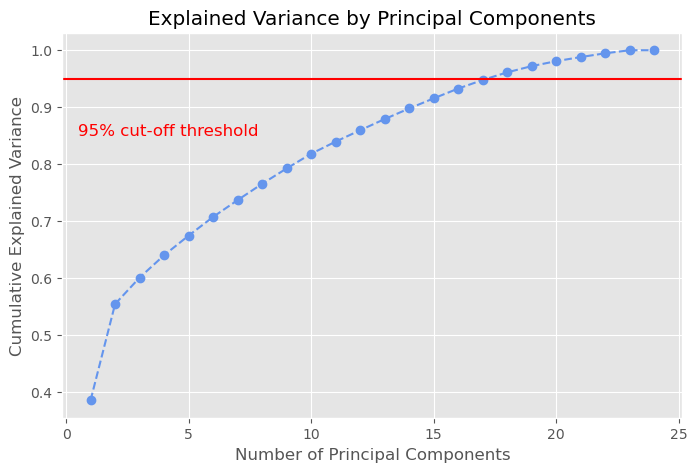

Optimal number of components: 18


In [27]:
# Fit PCA
pca = PCA()
pca.fit(data_reduced.iloc[:, 1:])

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--', color='cornflowerblue')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Principal Components')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=12)
plt.show()

# Determine the number of components that explain at least 95% of the variance
optimal_components = next(x[0] for x in enumerate(cumulative_explained_variance) if x[1] >= 0.95) + 1
print(f'Optimal number of components: {optimal_components}')

<b>Scree Plot</b>

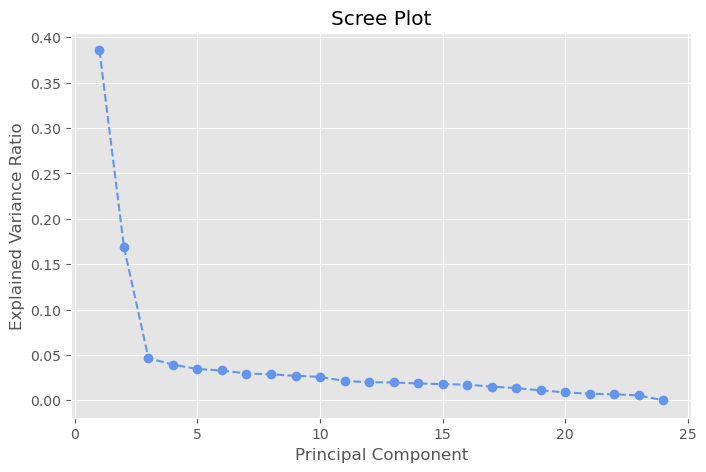

In [28]:
# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--', color='cornflowerblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

A scree plot shows the explained variance for each principal component. The "elbow" point in the plot indicates the optimal number of components.

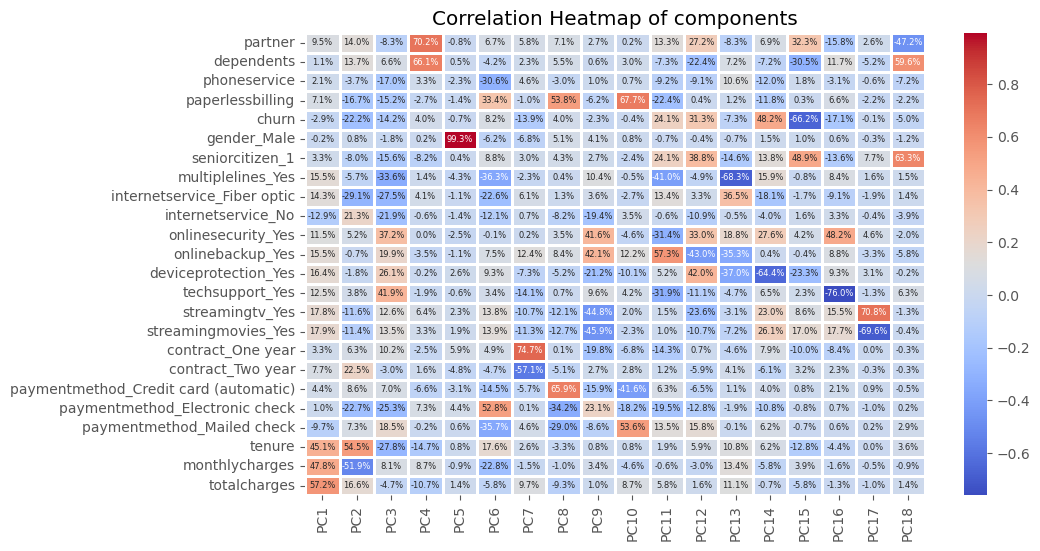

In [29]:
# Fit PCA
pca = PCA(n_components=18)  # Adjust the number of components to your actual needs
pca.fit(data_reduced.iloc[:, 1:])
# Extract loadings (components)
loadings = pd.DataFrame(pca.components_.T, columns=[f'PC{i+1}' for i in range(pca.n_components_)], index=data_reduced.iloc[:, 1:].columns)
# Create a heatmap of loadings
plt.figure(figsize=(10, 6))
sns.heatmap(loadings, annot=True, fmt='.1%', linewidths=1, cmap='coolwarm', annot_kws = {'size': 6})
plt.title('Correlation Heatmap of components')
plt.show()

In [30]:
# Create meaningful names based on loadings
def interpret_pca_loadings(loadings, top_n=2):
    component_names = []
    for col in loadings.columns:
        # Get the top_n features for each component
        top_features = loadings[col].abs().sort_values(ascending=False).head(top_n).index
        component_name = '+'.join(top_features)
        component_names.append(component_name)
    return component_names

# Generate meaningful names
component_names = interpret_pca_loadings(loadings)
component_names

['totalcharges+monthlycharges',
 'tenure+monthlycharges',
 'techsupport_Yes+onlinesecurity_Yes',
 'partner+dependents',
 'gender_Male+contract_One year',
 'paymentmethod_Electronic check+multiplelines_Yes',
 'contract_One year+contract_Two year',
 'paymentmethod_Credit card (automatic)+paperlessbilling',
 'streamingmovies_Yes+streamingtv_Yes',
 'paperlessbilling+paymentmethod_Mailed check',
 'onlinebackup_Yes+multiplelines_Yes',
 'onlinebackup_Yes+deviceprotection_Yes',
 'multiplelines_Yes+deviceprotection_Yes',
 'deviceprotection_Yes+churn',
 'churn+seniorcitizen_1',
 'techsupport_Yes+onlinesecurity_Yes',
 'streamingtv_Yes+streamingmovies_Yes',
 'seniorcitizen_1+dependents']

In [31]:
# Apply the component names to the principal components DataFrame
principal_components = pd.DataFrame(pca.transform(data_reduced.iloc[:, 1:]), columns=component_names)
principal_components.head()

,totalcharges+monthlycharges,tenure+monthlycharges,techsupport_Yes+onlinesecurity_Yes,partner+dependents,gender_Male+contract_One year,paymentmethod_Electronic check+multiplelines_Yes,contract_One year+contract_Two year,paymentmethod_Credit card (automatic)+paperlessbilling,streamingmovies_Yes+streamingtv_Yes,paperlessbilling+paymentmethod_Mailed check,onlinebackup_Yes+multiplelines_Yes,onlinebackup_Yes+deviceprotection_Yes,multiplelines_Yes+deviceprotection_Yes,deviceprotection_Yes+churn,churn+seniorcitizen_1,techsupport_Yes+onlinesecurity_Yes,streamingtv_Yes+streamingmovies_Yes,seniorcitizen_1+dependents
0,-1.911764,-0.276380,0.190513,0.308648,-0.467402,1.196822,0.127785,0.245063,0.675403,0.196838,0.405720,-0.331098,-0.502717,-0.184801,0.485833,0.077664,-0.019452,-0.548859
1,-0.501795,0.526451,0.873249,-0.606209,0.571330,-0.409855,0.755995,-0.520506,0.078328,-0.045118,-0.180369,0.837609,0.165734,-0.337851,-0.281909,0.463194,0.078359,-0.027239
2,-1.589443,-0.701239,0.805750,-0.334256,0.433537,-0.220041,-0.052086,0.309915,0.803016,0.843626,0.430026,0.210467,-0.072966,0.525131,-0.403240,0.506256,-0.001755,-0.209466
3,-0.343979,1.021365,1.113926,-0.762047,0.589497,0.478634,0.540169,-0.201588,0.236624,-0.521143,-0.532950,0.699944,-0.005226,-0.158448,-0.345016,-0.283122,0.071918,0.098643
4,-1.328062,-1.632801,-0.415641,-0.137920,-0.501077,0.298911,-0.101085,0.093552,0.298809,-0.009176,-0.020877,0.044605,0.522932,-0.153475,-0.449377,-0.168981,-0.045516,-0.137924
